# SETRED
The idea of rewriting the code of the repository is to get a coomprhensive understanding of the SETRED method. 

SETRED stands for self-training with Editing. 

Create a SETRED classifier. It is a self-training algorithm that uses a rejection mechanism to avoid adding noisy samples to the training set. 

The main process are:
1. Train a classifier with the labeled data
2. Create a pool of unalbeled data and select the most confident predictions. 
3. Repeat until the maximum number of iterations is reached. 

    - a. Select the most confident predictions from the unlabeled data. 
    - b. Calculate the neighborhood graph of the labeled data and the selected instances from the unlabeled data. 
    - c. Calculate the significance level of the selected instances (Statistic J_i, sum of cut edges )
    - d. Reject the instances that are not significant according to the statistics J_i.
    - e. Add the selected instances to the labeled data and retrain the classifier. 
    - f. Add new instances to the pool of unalabeled data. 
    
4. Return the classifier trained with the labeled data. 




In [1]:
# Common libraries
import numpy as np 
import pandas as pd 
from scipy.stats import norm 

# Sklearn libraries
# BaseEstimator is a helper class provided by scikit-learn to make it easier to create your own custom models or transformers that behave like 
# any other scikit-learn model. 
# MetaEstimatorMixin is a mixin class from sksklearn.base to help create meta-estimators, which are estimators that wrap other estimators.
from sklearn.base import BaseEstimator, MetaEstimatorMixin, ClassifierMixin
# The clone function creates a new copy of an estimator with the same parameters, but without any trained data, without any fitted attributes. 
from sklearn.base import clone as skclone 
from sklearn.base import is_classifier
from sklearn.ensemble._base import _set_random_states

# Models
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.semi_supervised import SelfTrainingClassifier

# Utils
from sklearn.utils import check_random_state, resample
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.metaestimators import available_if

# Selection classifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    log_loss)

from sklearn.metrics import classification_report

# Simulation functions
from sklearn.datasets import make_classification, make_blobs
from adspy_shared_utilities import plot_class_regions_for_classifier

# Visualization libraries
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Data
from sklearn.datasets import load_iris

# SSlearn library
from sslearn.utils import calculate_prior_probability, check_classifier
from sslearn.model_selection import artificial_ssl_dataset
from sslearn.wrapper import Setred

In [2]:
from setred_package import Setred_scratch

# Simulation

The simulation consists of:

- n: 13000 intances
- classes: 5 labels
- X: design matrix

In [3]:
# Parameters of the simulation
n = 13000 # Number of samples
K = 7 # Number of classes 5 are the number of types of myositis
p = 2 # Number of features
# Colors for data visulaization
import matplotlib.colors as mcolors
cmap_bold = ListedColormap(colors = [
    '#FF0000',  # Red
    '#00FF00',  # Lime Green
    '#0000FF',  # Blue
    '#800080',  # Purple
    '#00FFFF',  # Cyan / Aqua
    '#FFC0CB',  # Pink
    '#808080',  # Gray
    '#A52A2A',  # Brown
])

In [4]:
# Generation of data with make_blobs 
X_D2, y_D2 = make_blobs(n_samples = 13000, n_features = 2,
                       centers = K, cluster_std =2.5,
                       random_state = 42)

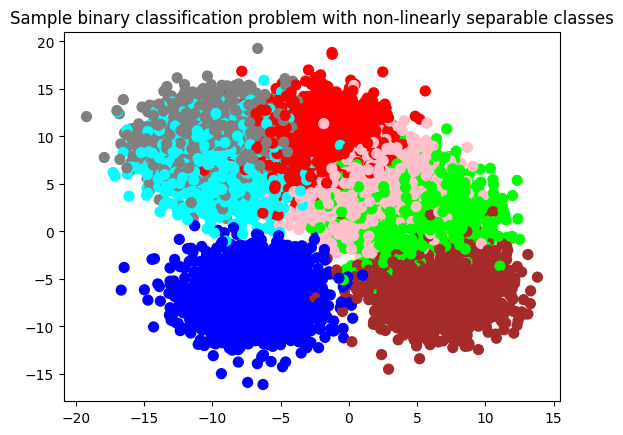

In [5]:
# Generation of labels
y_D2 = y_D2 % K
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

## Generation of artificial semisupervised learning


In [6]:
# Generate artificial semi-supervised learning dataset
X, y, X_unlabel, y_unlabel = artificial_ssl_dataset(X_D2, y_D2, label_rate=0.01, random_state=42)
# Print the shape of the datasets
print(f"Shape of X: {X.shape}, y: {y.shape}, X_unlabel: {X_unlabel.shape}, y_unlabel: {y_unlabel.shape}")
# Print the number of the classes in y
print(f"Frequencies of classes in y: {pd.Series(y).value_counts(normalize=False)}")


Shape of X: (13000, 2), y: (13000,), X_unlabel: (12870, 2), y_unlabel: (12870,)
Frequencies of classes in y: -1    12870
 3       23
 0       22
 1       19
 5       18
 2       18
 6       17
 4       13
Name: count, dtype: int64


In [7]:
# Filtering the labeled instances
X_label = X[y != -1]
y_label = y[y != -1]
# Spliting the dataset into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_label, y_label, test_size=0.5, random_state=42, stratify=y_label)
# Print the shape of the validation and testing sets
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
# Print the number of the classes in y_val and y_test
print(f"Frequencies of classes in y_val: {pd.Series(y_val).value_counts(normalize=False)}")
print(f"Frequencies of classes in y_test: {pd.Series(y_test).value_counts(normalize=False)}")


Shape of X_val: (65, 2), y_val: (65,), X_test: (65, 2), y_test: (65,)
Frequencies of classes in y_val: 3    12
0    11
1     9
5     9
2     9
6     9
4     6
Name: count, dtype: int64
Frequencies of classes in y_test: 3    11
0    11
1    10
2     9
5     9
6     8
4     7
Name: count, dtype: int64


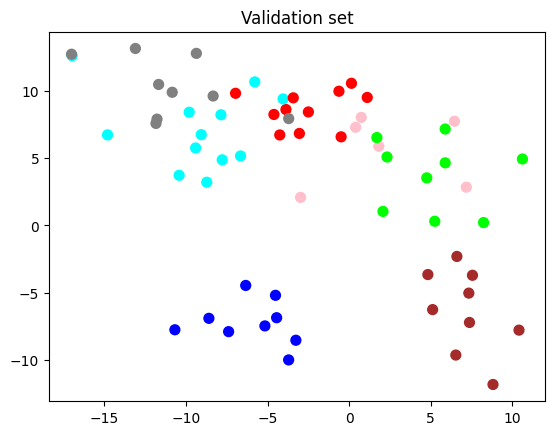

In [8]:
plt.figure()
plt.title('Validation set')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

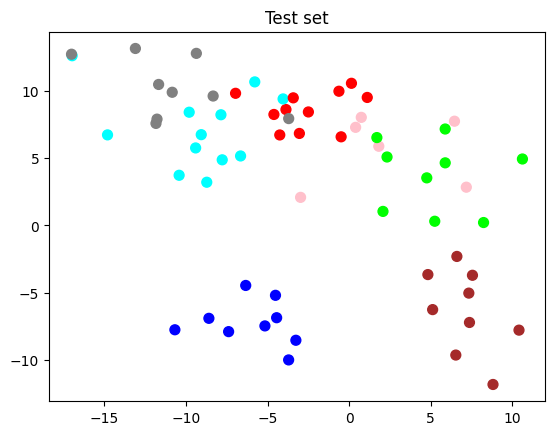

In [9]:
plt.figure()
plt.title('Test set')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

# Decision Tree

- Hyperparamter tunning with the validation data
- Check the performance of the classifier on the test data

In [10]:
# Fitting a decision tree with hyperparameters tunning using cross validation
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(dt, param_grid, cv=5)
print("The shape of X_val:", X_val.shape)
print("The shape of y_val:", y_val.shape)

grid_search.fit(X_val, y_val)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Base estimator
base_estimator_dt = DecisionTreeClassifier(**best_params, random_state=42)

The shape of X_val: (65, 2)
The shape of y_val: (65,)
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [11]:
# Fit the base estimator on the validation set
dt_fitted = base_estimator_dt.fit(X_val, y_val)

In [12]:
# Print the accuracy of the base estimator on the validation set
y_val_pred = base_estimator_dt.predict(X_val)
y_test_pred = base_estimator_dt.predict(X_test)
# Print the accuracy of the base estimator on the validation set
print(f"Accuracy of the base estimator on the validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_test_pred)}")
# Classification report
from sklearn.metrics import classification_report
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Accuracy of the base estimator on the validation set: 0.8461538461538461
Accuracy of the base estimator on the test set: 0.7384615384615385
Classification report on validation set:
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.82      1.00      0.90         9
           2       1.00      1.00      1.00         9
           3       0.83      0.83      0.83        12
           4       1.00      0.17      0.29         6
           5       0.88      0.78      0.82         9
           6       1.00      1.00      1.00         9

    accuracy                           0.85        65
   macro avg       0.88      0.81      0.80        65
weighted avg       0.87      0.85      0.83        65

Classification report on test set:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.90      0.72        10
           2       1.00 

In [13]:
# Predict the instances that are not labeled with the base estimator
y_unlabel_pred = base_estimator_dt.predict(X_unlabel)
# Print the accuracy of the base estimator on the unlabeled set
print(f"Accuracy of the base estimator on the unlabeled set: {accuracy_score(y_unlabel, y_unlabel_pred)}")
# Print the classification report on the unlabeled set
print("Classification report on unlabeled set:")
print(classification_report(y_unlabel, y_unlabel_pred))


Accuracy of the base estimator on the unlabeled set: 0.6786324786324787
Classification report on unlabeled set:
              precision    recall  f1-score   support

           0       0.57      0.81      0.66      1836
           1       0.57      0.77      0.66      1838
           2       0.98      0.99      0.99      1839
           3       0.53      0.61      0.57      1834
           4       0.50      0.06      0.10      1844
           5       0.64      0.55      0.59      1839
           6       0.88      0.96      0.92      1840

    accuracy                           0.68     12870
   macro avg       0.67      0.68      0.64     12870
weighted avg       0.67      0.68      0.64     12870



# K nearest neighbours

In [14]:
knn = KNeighborsClassifier()
# Hyperparameters for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['distance'],
    'p': [1, 2],  # 1 = Manhattan, 2 = Euclidean
    'metric': ['minkowski']
}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_val, y_val)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Base estimator
base_estimator_knn = KNeighborsClassifier(**best_params)
base_estimator_knn.fit(X_val, y_val)

Best parameters: {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

In [15]:
# Print the accuracy of the base estimator on the validation set
y_val_pred = base_estimator_knn.predict(X_val)
y_test_pred = base_estimator_knn.predict(X_test)
# Print the accuracy of the base estimator on the validation set
print(f"Accuracy of the base estimator on the validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_test_pred)}")
# Classification report
from sklearn.metrics import classification_report
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Accuracy of the base estimator on the validation set: 1.0
Accuracy of the base estimator on the test set: 0.7230769230769231
Classification report on validation set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         9

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65

Classification report on test set:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.53      0.80      0.64        10
           2       1.00      1.00      

In [16]:
# Predict the instances that are not labeled with the base estimator
y_unlabel_pred = base_estimator_knn.predict(X_unlabel)
# Print the accuracy of the base estimator on the unlabeled set
print(f"Accuracy of the base estimator on the unlabeled set: {accuracy_score(y_unlabel, y_unlabel_pred)}")
# Print the classification report on the unlabeled set
print("Classification report on unlabeled set:")
print(classification_report(y_unlabel, y_unlabel_pred))

Accuracy of the base estimator on the unlabeled set: 0.6762237762237763
Classification report on unlabeled set:
              precision    recall  f1-score   support

           0       0.61      0.70      0.65      1836
           1       0.53      0.77      0.63      1838
           2       0.99      0.99      0.99      1839
           3       0.52      0.55      0.54      1834
           4       0.51      0.19      0.28      1844
           5       0.66      0.56      0.60      1839
           6       0.88      0.96      0.92      1840

    accuracy                           0.68     12870
   macro avg       0.67      0.68      0.66     12870
weighted avg       0.67      0.68      0.66     12870



In [17]:
base_estimator_knn.predict_proba(X_unlabel)[2,:]

array([0.        , 0.        , 0.        , 0.17041206, 0.        ,
       0.82958794, 0.        ])

# SETRED CLASSIFIER

In [19]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Decision Tree

In [ ]:

# Fitting the Setred classifier
ssl_clf_dt = Setred_scratch(base_estimator=base_estimator_dt,
                         max_iterations=60,
                         graph_neighbors=100,                        
                         htunning=True,
                         param_grid={
                                'max_depth': [None, 5, 10, 15],
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4]
                            },
                        X_label_real=X_unlabel,
                        y_label_real=y_unlabel,
                        view = 10)
ssl_clf_dt.fit(X, y)


## KNN SETRED

In [20]:
ssl_clf_knn = Setred_scratch(base_estimator=base_estimator_knn,
                             graph_neighbors=20,
                             max_iterations=1,
                             htunning=True,
                             param_grid={
                                 'n_neighbors': [7, 9, 15, 20],
                                 'weights': ['distance'],
                                 'p': [1, 2],  # 1 = Manhattan, 2 = Euclidean
                                 'metric': ['minkowski']
                                            },
                            X_label_real=X_unlabel,
                            y_label_real=y_unlabel,
                            view = 1)
ssl_clf_knn.fit(X, y)


Iteration 1 - 130 labeled instances, 12870 unlabeled instances left
              precision    recall  f1-score   support

           0       0.61      0.89      0.72      1836
           1       0.56      0.86      0.67      1838
           2       0.98      1.00      0.99      1839
           3       0.59      0.59      0.59      1834
           4       0.67      0.12      0.20      1844
           5       0.67      0.52      0.59      1839
           6       0.92      0.94      0.93      1840

    accuracy                           0.70     12870
   macro avg       0.71      0.70      0.67     12870
weighted avg       0.71      0.70      0.67     12870



Setred_scratch(X_label_real=array([[-11.4487957 ,   9.4433448 ],
       [  7.68388517,  -9.009358  ],
       [-11.70978604,   6.7051456 ],
       ...,
       [ -7.11891814,   9.81178017],
       [ -8.10615778,  -7.58700791],
       [  4.40998688,   2.01323289]]),
               base_estimator=KNeighborsClassifier(n_neighbors=3, p=1,
                                                   weights='distance'),
               graph_neighbors=20, htunning=True, max_iterations=1,
               param_grid={'metric': ['minkowski'],
                           'n_neighbors': [7, 9, 15, 20], 'p': [1, 2],
                           'weights': ['distance']},
               view=1, y_label_real=array([3, 6, 3, ..., 3, 2, 1]))

In [21]:
ssl_clf_knn.weights_.shape

(130, 130)

In [22]:
# Sum the values in the prior_probabilities_ dictionary
total_prior_probabilities = sum(ssl_clf_knn.prior_probabilities_.values())
print(f"Total of prior probabilities: {total_prior_probabilities}")

Total of prior probabilities: 1.0


In [23]:
ssl_clf_knn.weights_.shape

(130, 130)

In [24]:
connected_id = np.nonzero(ssl_clf_knn.weights_[0,:])

In [25]:
ssl_clf_knn.iid_observed_

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1]])

In [26]:
matched_id = np.nonzero(np.abs(ssl_clf_knn.iid_observed_[0,:] - 1))
matched_id[0].shape

(23,)

In [27]:
np.isin(matched_id,connected_id ).sum()

8

In [28]:
for k in range(100):
    print(f"Connected id for k={k}: {np.nonzero(ssl_clf_knn.weights_[k, :])[0]}")
    print(ssl_clf_knn.iid_observed_[k,np.nonzero(ssl_clf_knn.weights_[k, :])[0]])

Connected id for k=0: [  3  31  36  41  44  48  86  99 116 121 128]
[0 0 0 0 1 0 0 0 1 0 1]
Connected id for k=1: [  1   7  20  35  38  50  51  62  67  71  75  84  85 115 117 125]
[0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1]
Connected id for k=2: [ 35  42  75  81  93 107 111 118 120]
[0 0 1 0 0 1 1 0 1]
Connected id for k=3: [  3   4  11  12  48  86  91 105 121]
[0 0 0 0 0 0 0 0 0]
Connected id for k=4: [ 22 110 119 120 123]
[0 0 0 0 0]
Connected id for k=5: [  6  30  53  79  92 122]
[0 0 0 0 0 0]
Connected id for k=6: [ 19  22  58  78 110 119 123]
[0 0 0 0 0 0 0]
Connected id for k=7: [ 35  42  81  93 111 118 119 120]
[0 0 0 0 1 0 1 1]
Connected id for k=8: [ 11  12  32  64  74  86 105 106]
[0 0 0 1 0 0 0 1]
Connected id for k=9: [ 10  27  29  39  49  56  76  89 102 113]
[0 0 0 0 1 0 0 0 1 0]
Connected id for k=10: [  8   9  17  21  47  57  65  66  97 100 108 126 127]
[0 1 0 0 0 0 0 0 1 1 0 0 0]
Connected id for k=11: [ 10  23  27  29  39  49  56  70  76  89  96 113]
[0 1 0 0 0 1 0 0 0 0 0 0]
Co

In [29]:
np.nonzero(ssl_clf_knn.weights_[1, :])[0]

array([  1,   7,  20,  35,  38,  50,  51,  62,  67,  71,  75,  84,  85,
       115, 117, 125])

In [30]:
np.sum(ssl_clf_knn.weights_[1, :] * ssl_clf_knn.iid_observed_[1,:])

1.7852482729770691

In [38]:
ssl_clf_knn.weights_[1, :].sum()* (1- ssl_clf_knn.p_wr)

4.737942506964663

In [31]:
ssl_clf_knn.jiobs_[1]

1.7852482729770691

In [32]:
ssl_clf_knn.ji_matrix_[1,:] < ssl_clf_knn.jiobs_[1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [33]:
mu0 = ssl_clf_knn.weights_[1, :].sum()*ssl_clf_knn.p_wrong_[1]
print(f"mu0 for k=2: {mu0}")

mu0 for k=2: 4.045473986715981


In [35]:
ssl_clf_knn.zobs_[1]

-5.236660014663055

In [36]:
ssl_clf_knn.oiobs_[1]

8.175424363356803e-08

In [ ]:
ssl_clf_knn.oi_matrix_[0,:] 

In [ ]:
ssl_clf_knn.jiobs_[27]


In [ ]:
ssl_clf_knn.oi_matrix_[27,:] 

In [ ]:
(ssl_clf_knn.zi_matrix_[27,:] < -1.96).mean()

In [ ]:
ssl_clf_knn._base_estimator

In [ ]:
ssl_clf_knn._base_estimator.n_neighbors

In [ ]:
# TREE CLASSIFIER
tree = ssl_clf_dt._base_estimator

In [ ]:
# Number of samples in the root node of the decision tree
tree.tree_.n_node_samples[0]

In [ ]:
classes = [ str(i) for i in range(K)]
# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=['feature_1','feature_2'], class_names= classes, filled=True)
plt.title("Decision Tree Trained ")
plt.show()

In [ ]:
title = 'Classifier with {}'.format('SETRED Decision Tree Classifier')
plot_class_regions_for_classifier(tree,X_val,y_val,X_test,y_test,title)
plt.tight_layout()

In [ ]:
title = 'Classifier with {}'.format('SETRED Decision Tree Classifier')
plot_class_regions_for_classifier(tree,X_val,y_val,title=title) 
plt.tight_layout()


In [ ]:
title = 'Classifier with {}'.format('SETRED Decision Tree Classifier')
plot_class_regions_for_classifier(tree,X_unlabel,y_unlabel,title=title) 
plt.tight_layout()

# Evaluation metrics

In [ ]:
# Generate predictions on the test set
y_pred = ssl_clf.predict(X_test)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
# Generate predictions on the test set
y_pred = ssl_clf.predict(X_unlabel)

# Generate the classification report
report = classification_report(y_unlabel, y_pred)
print(report)